# **Modello from Scratch**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%%capture
!pip install keras-tuner # libreria per il tuning degli iperparametri
!pip install visualkeras

In [3]:
import os
import random
import shutil
import zipfile
import numpy as np
import pandas as pd
from collections import Counter
from sklearn.utils import resample

# Plot immagini
import seaborn as sns
from skimage import io
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon

# Deep learning
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import image_dataset_from_directory
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.optimizers import SGD, Adam, RMSprop
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import Sequential, Model
from keras.layers import Dropout, Dense, Flatten, Conv2D, MaxPool2D, PReLU
from keras.layers import ZeroPadding2D, Convolution2D, MaxPooling2D
from sklearn.metrics import classification_report, confusion_matrix

# Optimization
# import keras_tuner as kt
# import visualkeras

# Recall
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import roc_curve
from tensorflow.keras.metrics import Recall
from sklearn.metrics import auc

In [4]:
DATA_PATH = '/content/drive/MyDrive/Progetto Data Lab/Dati/'
# train_path = DATA_PATH + 'dataset/train'
# test_path = DATA_PATH + 'dataset/test'
model_path = '/content/drive/MyDrive/Progetto Data Lab/Model/'

## Import images

In [5]:
train_path = DATA_PATH + 'train'
test_path = DATA_PATH + 'test'

In [6]:
def import_data(img_size = (96,96), val_split = 0.1, batch_size = 64,
                train_path = train_path, test_path = test_path):
  """
  Funzione per l'importazione delle immagini di training e di validation
  """
  image_generator = keras.preprocessing.image.ImageDataGenerator(rescale=1./255, 
                                                                 validation_split = val_split
                                                                 )
  # Training set
  train_set = image_generator.flow_from_directory(
      train_path, 
      class_mode = 'categorical', 
      classes = ['0', '1'], 
      color_mode = 'rgb',
      shuffle = True,
      target_size = img_size, 
      batch_size = batch_size, 
      subset = 'training', # carica un subset di training (90%)
      seed = 1
  )

  val_set = image_generator.flow_from_directory(
      train_path,
      classes = ['0', '1'],
      class_mode='categorical',
      color_mode = 'rgb',
      shuffle = False, 
      target_size = img_size,
      batch_size = batch_size,
      subset = 'validation', 
      seed = 1
  )

  # carico il test set
  test_set = image_generator.flow_from_directory(
      test_path,
      classes = ['0','1'], 
      class_mode='categorical',
      color_mode = 'rgb',
      shuffle = False, 
      target_size = img_size,
      batch_size = batch_size
  )

  return train_set, val_set, test_set

In [7]:
train_set, val_set, test_set = import_data()

Found 9000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


## Architettura *from scratch*

### Funzioni ausiliarie
In questa sezione sono raccolte una serie di funzioni che ci saranno utili in fase di addestramento e valutazione dei modelli. In particolare svolgono i seguenti compiti:
- addestramento del modello con la possibilità di scegliere se usare l'Early Stopping;
- calcolo della predizione;
- plot delle curve di loss e accuracy per il training e il validation set;
- visualizzazione dei risultati attraverso una serie di metriche e il plot della matrice di confusione.

In [8]:
def train_model(model, bs = 128, eps = 50, early_stopping = True, pat = 3,
                min_d = 0.001):
  """
  Viene eseguito il fit del modello su un numero di epoche fissato.
  :param keras.engine.functional.Functional model: modello da addestrare
  :param int bs: batch size
  :param int eps: numero di epoche desiderato
  :param bool early_stopping: parametro booleano che specifica se utilizzare o
  meno l'Early Stopping
  :param int pat: numero di epoche da eseguire se non si verificano miglioramenti
  :param float min_d: variazione minima richiesta
  """
  early_stop = None
  if early_stopping == True:
    early_stop = EarlyStopping(monitor = 'val_loss', patience = pat,
                               min_delta = min_d, restore_best_weights = True,
                               verbose = 1) 

    history = model.fit(train_set, epochs = eps, validation_data = val_set,
                        batch_size = bs, callbacks = [early_stop], verbose = 1)
    
  else:
    history = model.fit(train_set, epochs = eps, validation_data = val_set,
                        batch_size = bs, verbose = 1)
  return history, early_stop

In [9]:
def plot_history(history, early_stop = None, plot_size = (15,5)):
  """
  Visualizza a video alcune informazioni testuali di base sul training del
  modello e due grafici per analizzare l'andamento della loss e dell'accuracy
  durante il training
  
  :param keras.callbacks.History history: history del modello contenente i valori 
  di loss e accuracy per training e validation set
  :param keras.callbacks.EarlyStopping early_stop: early stopping utilizzato in
  fase di addestramento
  :param tuple plot_size: dimensione del plot
  """

  if early_stop is not None:
    if early_stop.stopped_epoch != 0:
      epochs = early_stop.stopped_epoch + 1
    else:
      early_stop.best_epoch + 1
    best_epoch = early_stop.best_epoch + 1
  else:
    epochs = len(history.epoch)
    best_epoch = epochs

  fig = plt.figure(figsize = plot_size)

  plt.subplot(1, 2, 1)
  plt.xlabel('Epochs'); plt.ylabel('Loss');  plt.title('Model loss')
  plt.xticks(np.arange(len(history.epoch)), np.arange(1, len(history.epoch)+1))
  plt.plot(range(0,best_epoch,1), 
           history.history['loss'][:best_epoch], '.-', color="C0") 
  plt.plot(range(0,best_epoch,1), 
           history.history['val_loss'][:best_epoch], '.-', color="C1")
  plt.plot(range(best_epoch-1, len(history.epoch),1), 
           history.history['loss'][best_epoch-1:], '.--', color="C0") 
  plt.plot(range(best_epoch-1, len(history.epoch),1), 
           history.history['val_loss'][best_epoch-1:], '.--', color="C1")
  plt.legend(['Training', 'Validation'])

  plt.subplot(1, 2, 2)
  plt.xlabel('Epochs'); plt.ylabel('Accuracy');  plt.title('Model accuracy')
  plt.xticks(np.arange(len(history.epoch)), np.arange(1, len(history.epoch)+1))
  plt.plot(range(0,best_epoch,1), 
           history.history['accuracy'][:best_epoch], '.-', color="C0") 
  plt.plot(range(0,best_epoch,1), 
           history.history['val_accuracy'][:best_epoch], '.-', color="C1")
  plt.plot(range(best_epoch-1, len(history.epoch),1), 
           history.history['accuracy'][best_epoch-1:], '.--', color="C0") 
  plt.plot(range(best_epoch-1, len(history.epoch),1), 
           history.history['val_accuracy'][best_epoch-1:], '.--', color="C1") 
  plt.legend(['Training', 'Validation'], loc='lower right')

  print('Informazioni utili: \n')
  print('Numero di epoche totali:', epochs)
  print('Epoca migliore (weights restored):', best_epoch)
  print('Accuracy training set all\'epoca ' + str(best_epoch) + ': ' 
        + str(history.history['accuracy'][best_epoch -1]))
  print('Accuracy validation set all\'epoca ' + str(best_epoch) + ': '
        + str(history.history['val_accuracy'][best_epoch -1]))
  print('Loss training set all\'epoca ' + str(best_epoch) + ': '
        + str(history.history['loss'][best_epoch -1]))
  index = history.history['val_loss'].index(early_stop.best)
  print('Loss validation set all\'epoca ' + str(best_epoch) + ': ' 
        + str(history.history['val_loss'][index]))
  print('\n\n')

In [10]:
def make_prediction(model, test_set):
  """
  Determina la classificazione per il test set dato un modello
  :param keras.engine.functional.Functional model: modello usato per la
  classificazione
  :param BatchDataset: testing set
  """
  y_prediction = model.predict(test_set)
  y_pred = []
  for i in range(len(y_prediction)):
    y_pred.append(np.argmax(y_prediction[i]))
  y_pred = np.array(y_pred)

  return y_pred

In [11]:
def evaluate_prediction(model, y_test, y_pred, labels, plot_size = (15,15),
                        dpi = 100, color = "PuRd"): 
  """
  Calcola e visualizza graficamente alcune metriche sulle predizioni
  
  :param keras.engine.functional.Functional model: modello keras trainato con
  cui effettuare le predizioni
  :param string y_test: lista contenente le label del test set
  :param string y_pred: lista contenente le label della classificazione
  :param string labels: lista contenente i nomi dei pittori
  """
  # Classification report
  cl = classification_report(y_test, y_pred, target_names = labels)
  print('\nClassification Report\n', cl)

  # Confusion matrix
  cm = confusion_matrix(y_test, y_pred)

  fig, ax = plt.subplots(figsize=plot_size, dpi=dpi)
  sns.heatmap(cm, annot=True, fmt='g', cmap=color) 
  ax.set_title('Confusion Matrix');
  ax.set_xlabel('Predicted labels'); ax.set_ylabel('Actual labels');
  ax.xaxis.set_ticklabels(labels); ax.yaxis.set_ticklabels(labels);
  plt.xticks(rotation='vertical'); plt.yticks(rotation='horizontal')


In [12]:
def plot_roc(y_test, y_hat):
  fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, y_hat)
  auc_keras = auc(fpr_keras, tpr_keras)

  plt.figure()
  plt.plot(fpr_keras,tpr_keras)

  plt.xlabel('False positive rate')
  plt.ylabel('True positive rate')
  plt.title('ROC curve')
  plt.text(x=0.4, y=0.4 , s = f'AUC: {round(auc_keras,3)}', bbox = dict(boxstyle= 'square', color = 'lightblue'), fontsize = 16)
  plt.show()

### **Model**

In [ ]:
INPUT_SHAPE = (96,96,3)
NUM_CLASSES = 2
# Net parameter
pool_size = (2,2)
dropout_rate = 0.5
lr = 0.0001

In [ ]:
inputs = keras.Input(shape=INPUT_SHAPE)
x = inputs
# Convolutional Block
x = keras.layers.Conv2D(256, kernel_size = 3, activation = 'relu')(x)
x = keras.layers.MaxPooling2D(pool_size = pool_size)(x)
x = keras.layers.Conv2D(256, kernel_size = 5, activation = 'relu')(x)
x = keras.layers.MaxPooling2D(pool_size = pool_size)(x)
x = keras.layers.Conv2D(64, kernel_size = 3, activation = 'relu')(x)
x = keras.layers.MaxPooling2D(pool_size = pool_size)(x)
x = keras.layers.Dropout(dropout_rate)(x)
x = keras.layers.Flatten()(x)
# Dense Block
x = keras.layers.Dense(256, activation = 'relu')(x)
x = keras.layers.Dropout(dropout_rate)(x)
# Output layer
outputs = keras.layers.Dense(2, activation = 'sigmoid')(x)

model = model = keras.Model(inputs = inputs, outputs = outputs)


In [ ]:
model.compile(optimizer = Adam(lr),
                  loss = 'binary_crossentropy',
                  metrics = ['accuracy',Recall(name = 'recall')])

In [ ]:
history, early_stopping = train_model(model, bs = 64, eps = 25, early_stopping = True, pat = 5)

Epoch 1/25
141/141 [==============================] - 1301s 9s/step - loss: 0.6297 - accuracy: 0.6303 - recall: 0.6464 - val_loss: 0.4895 - val_accuracy: 0.7700 - val_recall: 0.7680
Epoch 2/25
141/141 [==============================] - 20s 144ms/step - loss: 0.5069 - accuracy: 0.7630 - recall: 0.7626 - val_loss: 0.4614 - val_accuracy: 0.7970 - val_recall: 0.7980
Epoch 3/25
141/141 [==============================] - 20s 143ms/step - loss: 0.4893 - accuracy: 0.7742 - recall: 0.7742 - val_loss: 0.4492 - val_accuracy: 0.8130 - val_recall: 0.8090
Epoch 4/25
141/141 [==============================] - 20s 143ms/step - loss: 0.4827 - accuracy: 0.7767 - recall: 0.7736 - val_loss: 0.4806 - val_accuracy: 0.7750 - val_recall: 0.7750
Epoch 5/25
141/141 [==============================] - 20s 143ms/step - loss: 0.4760 - accuracy: 0.7807 - recall: 0.7790 - val_loss: 0.4487 - val_accuracy: 0.8160 - val_recall: 0.8130
Epoch 6/25
141/141 [==============================] - 20s 141ms/step - loss: 0.4790 - 

In [ ]:
pred = make_prediction(model, test_set)


Classification Report
               precision    recall  f1-score   support

          No       0.89      0.68      0.77      1000
          Sì       0.74      0.92      0.82      1000

    accuracy                           0.80      2000
   macro avg       0.82      0.80      0.80      2000
weighted avg       0.82      0.80      0.80      2000



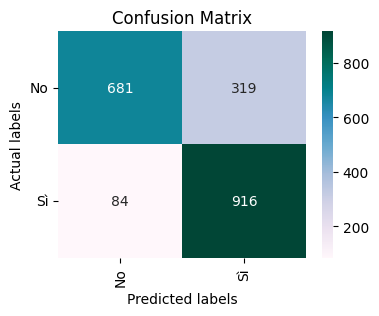

In [ ]:
evaluate_prediction(model, test_set.labels, pred, ['No','Sì'],
                    plot_size = (4,3), dpi = 100, color = 'PuBuGn')

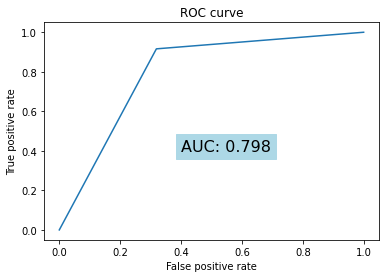

In [ ]:
plot_roc(test_set.labels, pred)

In [ ]:
model.save(model_path + 'net_scratch_trained_recall.h5')

### Model Optimization

In [ ]:
# Iperparametri del modello
early_stop = EarlyStopping(monitor = 'val_loss', patience = 4, min_delta = 0.001, 
                           verbose = 1, restore_best_weights = True) 


initializer = tf.keras.initializers.GlorotUniform(seed = 44) #seed random per garantire replicabilità

input_shape = (96,96,3) 
num_classes = 2

In [ ]:
def model_builder(hp):
  model = keras.models.Sequential()

  model.add(keras.Input(shape = input_shape))

  # BLOCCO CONVOLUZIONALE

  hp_num_conv = hp.Int('num_conv', min_value = 1, max_value = 3, step = 1 , default= 3)
  pool_size = (2,2)

  hp_activation = hp.Choice('activation', values=['relu', 'leaky_relu'], default = 'relu') 
  if hp_activation == 'leaky-relu':
    activation = keras.layers.LeakyReLU(alpha=0.01)
  else:
    activation = hp_activation

  # primo layer convoluzionale
  hp_filter_1 = hp.Choice('filter_1', values=[32, 64, 128, 256], default = 128) 
  hp_kernel_size_1 = hp.Choice('kenel_size_1', values = [3, 5, 7], default = 3) 
  model.add(tf.keras.layers.Conv2D(hp_filter_1, hp_kernel_size_1, padding="valid",
                                    activation=activation, kernel_initializer=initializer))
  model.add(tf.keras.layers.MaxPool2D(pool_size=pool_size))
  # secondo layer convoluzionale
  if hp_num_conv >= 2:
    hp_filter_2 = hp.Choice('filter_2', values=[32, 64, 128, 256], default = 128) 
    hp_kernel_size_2 = hp.Choice('kenel_size_2', values = [3, 5], default = 3) 
    
    model.add(tf.keras.layers.Conv2D(hp_filter_2, hp_kernel_size_2, padding="valid",
                                      activation=activation, kernel_initializer=initializer))  
    model.add(tf.keras.layers.MaxPool2D(pool_size=pool_size))
  # terzo layer convoluzionale
  if hp_num_conv >= 3:
    hp_filter_3 = hp.Choice('filter_3', values=[32, 64, 128, 256], default = 128) 
    hp_kernel_size_3 = hp.Choice('kenel_size_3', values = [3, 5], default = 3) 

    model.add(tf.keras.layers.Conv2D(hp_filter_3, hp_kernel_size_3, padding="valid",
                                     activation=activation, kernel_initializer=initializer))
    model.add(tf.keras.layers.MaxPool2D(pool_size=pool_size))

  hp_dropout_conv_value = hp.Choice('dropout_conv', values=[0.0, 0.2, 0.3,0.5], default = 0.3)
  if hp_dropout_conv_value != 0:
    model.add(Dropout(hp_dropout_conv_value))

  model.add(tf.keras.layers.Flatten())
  
  # BLOCCO FULLY CONNECTED

  hp_dense = hp.Boolean('dense')
  if hp_dense:
    hp_dense_size = hp.Choice('dense_size', values=[64, 128, 256], default = 256) 
    model.add(tf.keras.layers.Dense(hp_dense_size, activation = activation, 
                                    kernel_initializer= initializer))

    hp_dropout_dense = hp.Choice('dropout_dense', values=[0.0, 0.2, 0.5], default = 0.5) 
    if hp_dropout_dense != 0:
      model.add(Dropout(hp_dropout_dense))


  model.add(tf.keras.layers.Dense(num_classes, activation="sigmoid", 
                                  kernel_initializer=initializer))


  # Scelta dell'algoritmo di ottimizzazione e del learning rate
  hp_optimizer = hp.Choice('optimizer', values=['adam', 'SGD', 'rmsprop'], default = 'adam')
  optimizer = tf.keras.optimizers.get(hp_optimizer)
  optimizer.learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4], default = 1e-3)
                                      
  model.compile(optimizer = optimizer, 
                loss = 'binary_crossentropy', 
                metrics = ['accuracy'])

  return model

In [ ]:
# Inizializzazione del tuner
tuner = kt.BayesianOptimization(model_builder,
                                objective = kt.Objective('val_loss', direction = 'min'),
                                directory = model_path + 'keras_tuner',
                                max_trials = 20, overwrite = False,
                                project_name = 'model__opt_loss')

In [ ]:
# Ricerca degli iperparamtri migliori
tuner.search(train_set, epochs = 25, validation_data = val_set, shuffle = True,
             callbacks=[early_stop])

Trial 20 Complete [00h 01m 39s]
val_loss: 0.40900638699531555

Best val_loss So Far: 0.3608494699001312
Total elapsed time: 01h 34m 08s
INFO:tensorflow:Oracle triggered exit


In [ ]:
tuner.results_summary()

In [ ]:
# Best iperpametri
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
best_hps.values

{'activation': 'relu',
 'dense': True,
 'dense_size': 256,
 'dropout_conv': 0.5,
 'dropout_dense': 0.5,
 'filter_1': 256,
 'filter_2': 256,
 'filter_3': 64,
 'kenel_size_1': 3,
 'kenel_size_2': 5,
 'kenel_size_3': 3,
 'learning_rate': 0.0001,
 'num_conv': 3,
 'optimizer': 'rmsprop'}

In [ ]:
# Loading the best model
best_model = tuner.get_best_models(num_models=1)[0]
best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 94, 94, 256)       7168      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 47, 47, 256)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 43, 43, 256)       1638656   
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 21, 21, 256)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 19, 19, 64)        147520    
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 9, 9, 64)         0

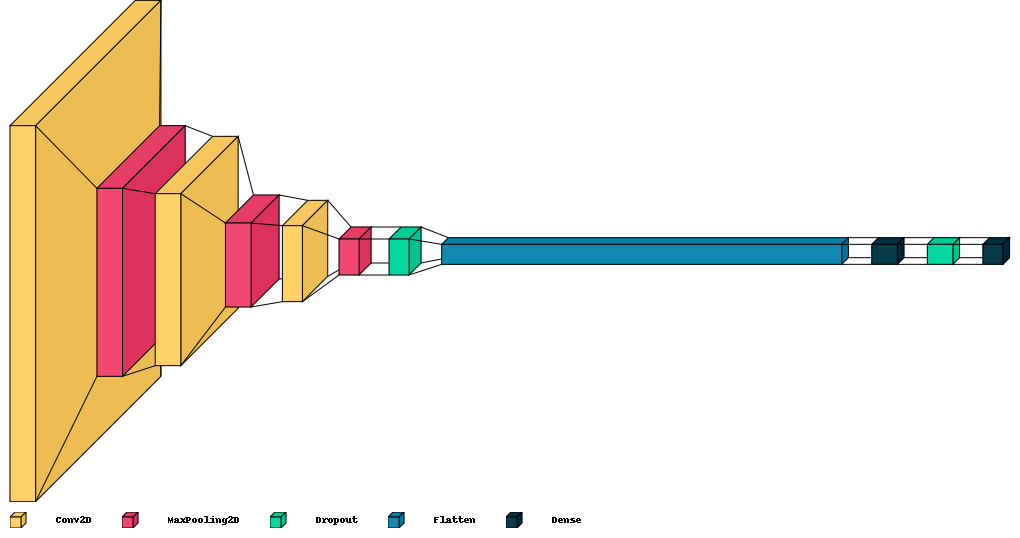

In [ ]:
visualkeras.layered_view(best_model, legend=True,spacing=30)

In [ ]:
best_model.save(model_path + 'best_model.h5')

In [ ]:
history, early_stopping = train_model(best_model, bs = 64, eps = 25, early_stopping = True, pat = 5)

Epoch 1/25
103/103 [==============================] - 14s 131ms/step - loss: 0.3733 - accuracy: 0.8364 - val_loss: 0.3571 - val_accuracy: 0.8526
Epoch 2/25
103/103 [==============================] - 13s 130ms/step - loss: 0.3705 - accuracy: 0.8405 - val_loss: 0.4274 - val_accuracy: 0.8085
Epoch 3/25
103/103 [==============================] - 13s 130ms/step - loss: 0.3631 - accuracy: 0.8436 - val_loss: 0.4554 - val_accuracy: 0.8058
Epoch 4/25
103/103 [==============================] - 14s 130ms/step - loss: 0.3610 - accuracy: 0.8436 - val_loss: 0.3900 - val_accuracy: 0.8361
Epoch 5/25
103/103 [==============================] - 14s 131ms/step - loss: 0.3552 - accuracy: 0.8436 - val_loss: 0.3546 - val_accuracy: 0.8581
Epoch 6/25
103/103 [==============================] - 14s 131ms/step - loss: 0.3519 - accuracy: 0.8475 - val_loss: 0.3676 - val_accuracy: 0.8457
Epoch 7/25
103/103 [==============================] - 13s 130ms/step - loss: 0.3496 - accuracy: 0.8514 - val_loss: 0.3486 - val_ac

In [ ]:
best_model.save(model_path + 'best_model_trained.h5')

### Testing

In [13]:
model = keras.models.load_model(model_path + 'best_model_trained.h5')

In [14]:
pred = make_prediction(model, test_set)


Classification Report
               precision    recall  f1-score   support

          No       0.76      0.91      0.83      1000
          Sì       0.88      0.71      0.79      1000

    accuracy                           0.81      2000
   macro avg       0.82      0.81      0.81      2000
weighted avg       0.82      0.81      0.81      2000



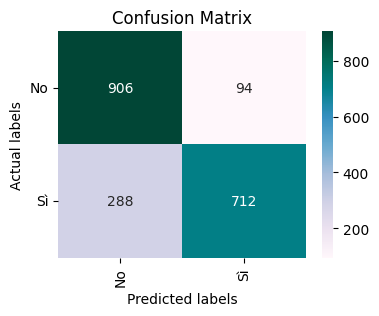

In [15]:
evaluate_prediction(model, test_set.labels, pred, ['No','Sì'],
                    plot_size = (4,3), dpi = 100, color = 'PuBuGn')

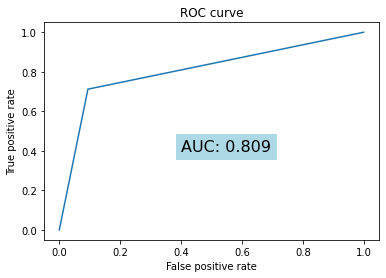

In [16]:
plot_roc(test_set.labels, pred)